# The Shyft `api`

## Introduction
At its core, Shyft provides functionality through an API (Application Programming Interface). Core functionality of Shyft is available through this API.

We begin the tutorials by introducing the API as it provides the building blocks for the framework. Once you have a good understanding, you can move toward configured runs that make use of `orchestation`. To make use of configured runs, you need to understand how we 'serialize' configurations and input data through `repositories`.

In [a separate](run_nea_nidelva.ipynb) of the simulation tutorials, we cover conducting a very simple simulation of an example catchment using configuration files. This is a typical use case, but assumes that you have a model well configured and ready for simulation. In practice, one is interested in working with the model, testing different configurations, and evaluating different data sources.

This is in fact a key idea of Shyft -- to make it simple to evaluate the impact of the selection of model routine on the performance of the simulation. In this notebook we walk through this lower level paradigm of working with the toolbox and using the Shyft `api` directly to conduct the simulations.


## 1. Loading required python modules and setting path to SHyFT installation

For the notebook tutorials we require several imports. In addition, be sure your [*shyft environment*](file:///Data/johnbur/workspace/shyft_workspace/shyft-doc/docs/html/shyft_env.html) is correctly configured. This is required **before** importing shyft itself. Lastly, import the `shyft` classes and modules.

In [1]:
# Pure python modules and jupyter notebook functionality
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%matplotlib inline
import os
import sys
import datetime as dt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from netCDF4 import Dataset

In [2]:
# try to auto-configure the path. This will work in the case
# that you have checked out the doc and data repositories
# at same level. Make sure this is done **before** importing shyft
shyft_data_path = os.path.abspath("../../../shyft-data")
if os.path.exists(shyft_data_path) and 'SHYFT_DATA' not in os.environ:
    os.environ['SHYFT_DATA']=shyft_data_path

# shyft should be available either by it's install in python
# or by PYTHONPATH set by user prior to starting notebook.
# If you have cloned the repositories according to guidelines:
# shyft_path=os.path.abspath('../../../shyft')
# sys.path.insert(0,shyft_path)

In [3]:
from shyft import api
import shyft.api.pt_gs_k
from shyft import shyftdata_dir



## 2. Build a Shyft model
The first point of simulation is to define the model that you will create. In this example, we will use Shyft's pure `api` approach to create a model from scratch.


### The simulation domain
What is required to set up a simulation? At the most basic level of Shyft, we need to define the simulation domain / geometry. Shyft does not care about the specific shape of the cells. Shyft just needs a 'geocentroid location' and an area. We will create a container of this information as a first step to provide to one of Shyft's model types later.

We are going to be working with the data from the Nea-Nidelva catchment, example dataset. This is available in the [shyft-data](https://github.com/statkraft/shyft-data) repository. Above, you should have set your `SHYFT_DATA` environment variable to point to this directory so that we can easily read the data.

The first thing to do is to take a look at the geography of our cells.



Text(0.5,1,'Nea Nidelva Catchment')

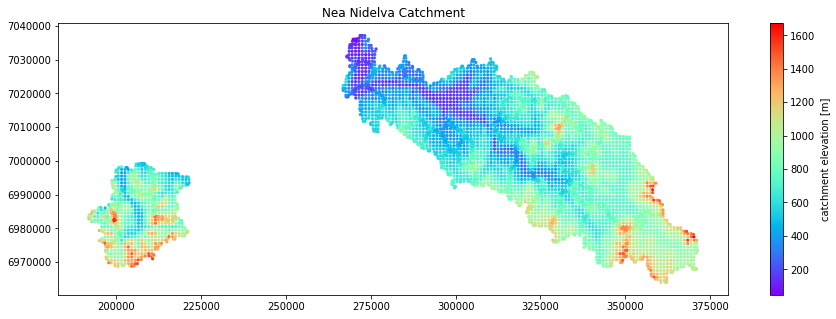

In [4]:
# load the data from the example datasets
cell_data = Dataset( os.path.join(shyftdata_dir, 'netcdf/orchestration-testdata/cell_data.nc'))

# plot the coordinates of the cell data provided
# fetch the x- and y-location of the cells
x = cell_data.variables['x'][:]
y = cell_data.variables['y'][:]
z = cell_data.variables['z'][:]
cid = cell_data.variables['catchment_id'][:]

# and make a quick catchment map...
# using a scatter plot of the cells
fig, ax = plt.subplots(figsize=(15,5))
cm = plt.cm.get_cmap('rainbow')
elv_col = ax.scatter(x, y, c=z, marker='.', s=40, lw=0, cmap=cm)
# cm = plt.cm.get_cmap('gist_gray')
# cid_col = ax.scatter(x, y, c=cid, marker='.', s=40, lw=0, alpha=0.4, cmap=cm)
plt.colorbar(elv_col).set_label('catchment elevation [m]')
# plt.colorbar(cid_col).set_label('catchment indices [id]')
plt.title('Nea Nidelva Catchment')
# print(set(cid))

### Create a collection of simulation cells
In Shyft we work with 'cells', which is the basic simulation unit. In the example netcdf file, we provide the attributes for the cells we are going to plot. But you made need to extract this information from your own GIS, or other data. The essential variables that are minimally required include:

* x, generally an easting coordinate in UTM space, [meters]
* y, generally a northing coordinate in UTM space, [meters]
* z, elevation [meters]
* area, the area of the cell, [square meters]
* land cover type fractions (these are float values that sum to 1):
    * glacier
    * lake
    * reservoir
    * forest
    * unspecified
* catchment_id, an integer to associate the cell with a catchment
* a radiation factor (set to 0.9 by default)

If you look at the netcdf file, you'll see these are included:

In [5]:
print(cell_data.variables.keys())


odict_keys(['x', 'y', 'z', 'crs', 'area', 'forest-fraction', 'reservoir-fraction', 'lake-fraction', 'glacier-fraction', 'catchment_id'])


So the first step is to extract these from the netcdf file, and get them into the model. Note that extracting these values is a pre-processing step that you will likely use a GIS system for. We do not cover that in this notebook.

In [6]:
# Let's first create a 'container' that will hold all of our model domains cells:
cell_data_vector = api.GeoCellDataVector()

# help(cell_data_vector)
#help(api.GeoPoint)

# from the netcdf file dimensions
num_cells = cell_data.dimensions['cell'].size

for i in range(num_cells):

    gp = api.GeoPoint(x[i], y[i], z[i]) # recall, we extracted x,y,z above
    cid = cell_data.variables['catchment_id'][i]
    cell_area = cell_data.variables['area'][i]

    # land fractions:
    glac = cell_data.variables['glacier-fraction'][i]
    lake = cell_data.variables['lake-fraction'][i]
    rsvr = cell_data.variables['reservoir-fraction'][i]
    frst = cell_data.variables['forest-fraction'][i]
    unsp = 1 - (glac + lake + rsvr + frst)
    
    land_cover_frac = api.LandTypeFractions(glac, lake, rsvr, frst, unsp)
    
    rad_fx = 0.9
    # note, for now we need to make sure we cast some types to pure python, not numpy
    geo_cell_data = api.GeoCellData(gp, float(cell_area), int(cid), rad_fx, land_cover_frac)

    cell_data_vector.append(geo_cell_data)


In [7]:
# put it all together to initialize a model, we'll use PTGSK

params = api.pt_gs_k.PTGSKParameter()
model = api.pt_gs_k.PTGSKModel(cell_data_vector, params)


In [8]:
# now get the forcing data ready.
# first create a region_environment object, the 'container' that will hold all 
# the forcing data sources
# re = api.ARegionEnvironment()

# # map the variable names in the netcdf file to the source types
# source_map = {'precipitation' : (api.PrecipitationSource, re.precipitation),
#              'radiation' : (api.RadiationSource, re.radiation),
#              'temperature' : (api.TemperatureSource, re.temperature),
#              'wind_speed' : (api.WindSpeedSource, re.wind_speed), 
#              'relative_humidity' : (api.RelHumSource, re.rel_hum) }

# # load the data from the example datasets
# station_met = Dataset( os.path.join(shyftdata_dir, 'netcdf/orchestration-testdata/stations_met.nc'))

# for station in station_met.groups.keys():
#     stn = station_met.groups[station]
#     print(stn)
#     time = api.UtcTimeVector([int(t) for t in stn.variables['time'][:]])
#     delta_t = time[1] - time[0] if len(time) > 1 else api.deltahours(1)
#     x = stn.x
#     y = stn.y
#     z = stn.z
#     gp = api.GeoPoint(x, y, z)
#     for var, (source, source_vec) in source_map.items():
#         if var in stn.variables.keys():
#             data = stn.variables[var][:]
        
#             time_axis = api.TimeAxis(int(time[0]), api.deltahours(delta_t), len(time))  
#             cts = api.TsFactory().create_time_point_ts(time_axis.total_period(), time, data, api.POINT_AVERAGE_VALUE)
#             # add it to the precipitation source
#             source_vec.append(source(gp, cts))

### ANOTHER APPROACH

In [9]:
re = api.ARegionEnvironment()

# map the variable names in the netcdf file to the source types
source_map = {'precipitation' : ('precipitation.nc', api.PrecipitationSource, re.precipitation),
             'global_radiation' : ('radiation.nc', api.RadiationSource, re.radiation),
             'temperature' : ('temperature.nc', api.TemperatureSource, re.temperature),
             'wind_speed' : ('wind_speed.nc', api.WindSpeedSource, re.wind_speed), 
             'relative_humidity' : ('relative_humidity.nc', api.RelHumSource, re.rel_hum) }

for var, (file_name, source_type, source_vec) in source_map.items():
    nci = Dataset( os.path.join(shyftdata_dir, 'netcdf/orchestration-testdata/' + file_name))
    
    time = api.UtcTimeVector([int(t) for t in nci.variables['time'][:]])
    delta_t = time[1] - time[0] if len(time) > 1 else api.deltahours(1)
    for i in range(nci.dimensions['station'].size):
        x = nci.variables['x'][i]
        y = nci.variables['y'][i]
        z = nci.variables['z'][i]
        gp = api.GeoPoint(x, y, z)
        data = nci.variables[var][:, i]
        time_axis = api.TimeAxis(int(time[0]), api.deltahours(delta_t), len(time))  
        dts = api.TsFactory().create_time_point_ts(time_axis.total_period(), 
                                                   time, data, api.POINT_AVERAGE_VALUE)
        # add it to the variable source vector
        source_vec.append(source_type(gp, dts))
    nci.close()

/Data/johnbur/.conda/envs/shyft-doc/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


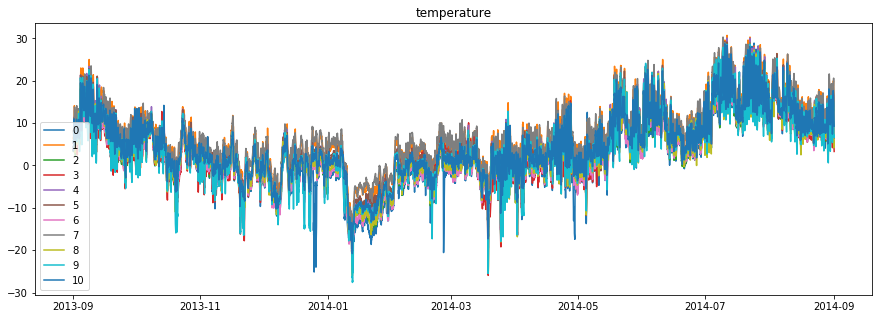

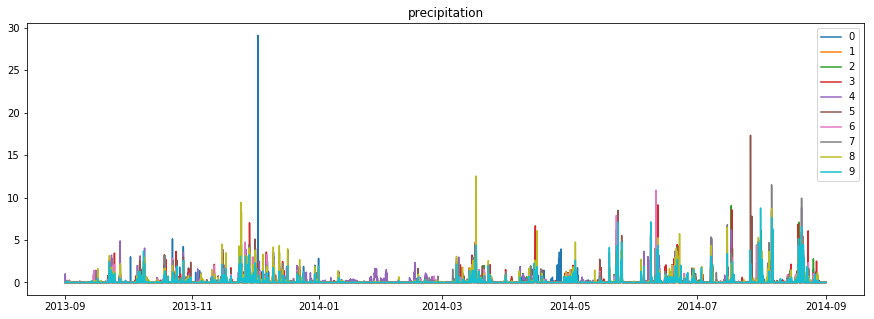

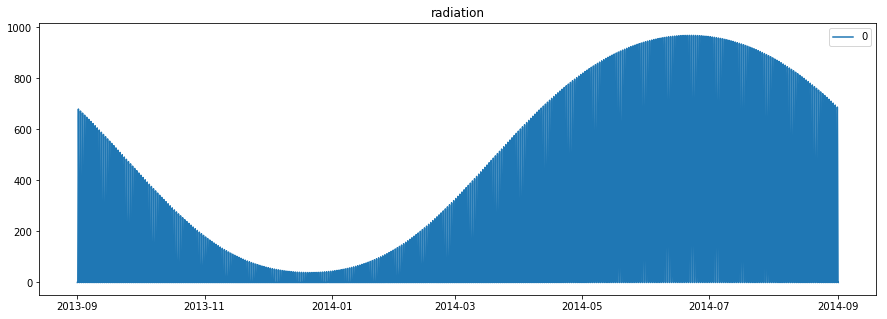

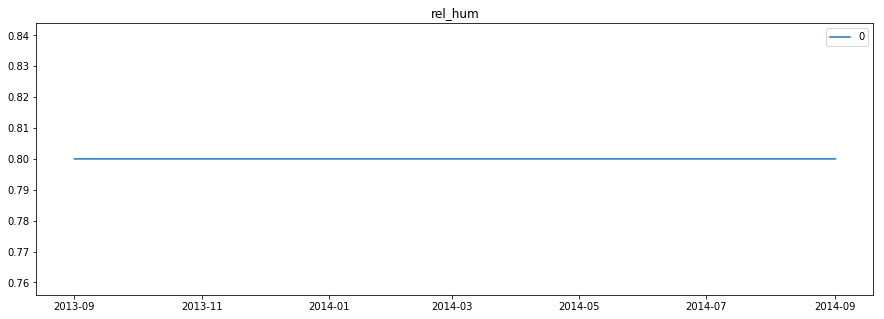

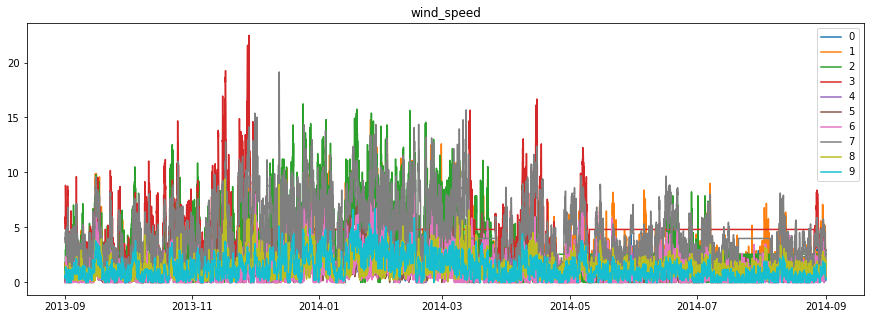

In [10]:
# let's take a look at the 'source' data.
# this is exactly the data that will be 'fed' to the interpolation routines
region_environment = re

def plot_station_data(region_environment):
    """ plot the data within each source vector of the `ARegionEnvironment`
    
    """

    for fv, sv in region_environment.variables:
        
        n_stn = len(sv)
        fig, ax = plt.subplots(figsize=(15,5))
        for stn in range(n_stn):
            t, d = [dt.datetime.utcfromtimestamp(t_.start) for t_ in sv[stn].ts.time_axis], sv[stn].ts.values
            ax.plot(t, d, label=stn)
            
        plt.title(fv)
        plt.legend()

plot_station_data(region_environment)
    

In [11]:
# next step, distribute the data to the cells
# we need to prepare for the interpolation 
# and define the length of the simulation (e.g. time_axis)
# 1. define the time_axis of the simulation:
cal = api.Calendar()
simulation_ta = api.TimeAxisFixedDeltaT(cal.time(2013, 9, 1, 0, 0, 0), api.deltahours(1), 8600)
# 2. interpolate the data from the region_environment to the model cells:
model_interpolation_parameter = api.InterpolationParameter()
model.run_interpolation(model_interpolation_parameter, simulation_ta, region_environment)

True

In [12]:
# at this point we could look at the time series for every cell. Or plot a spatial map...
# TODO: https://data-dive.com/cologne-bike-rentals-interactive-map-bokeh-dynamic-choropleth
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.palettes import viridis


forcing_variables = [fv for fv, sv in region_environment.variables]

output_notebook()
p = figure(title='Forcing Variables', plot_height=300, plot_width=800)
pallette = viridis(100)
cells = model.get_cells()
x = np.array([cell.geo.mid_point().x for cell in cells])
y = np.array([cell.geo.mid_point().y for cell in cells])

def plot_cell_data(model, fv, time_step):
    """ plot the data for each cell in the model
    
    Note
    -----
    This is for demonstration only. Normally one would plot the input data from the
    netcdf file directly, but the purpose is to show one how the data is containerized
    within Shyft.
    
    """
    if fv == 'temperature': minv, maxv = -40, 40
    if fv == 'precipitation': minv, maxv = 0, 400
    if fv == 'wind_speed': minv, maxv = 0, 10
    else: minv, maxv = -1, 1
    
    def rgb(minv, maxv, val, n, pallette):
        dd = np.linspace(minv, maxv, n) 
        idx = (np.abs(dd - val)).argmin()
        return pallette[idx]
        
    # Once we have the cells, we can get their coordinate information
    # and fetch the x- and y-location of the cells

    data = np.array([getattr(c.env_ts,fv).values[time_step] for c in cells])
    colors = [rgb(minv, maxv, d, 100, pallette) for d in data]
    r = p.scatter(x, y, radius=300, fill_color=colors, fill_alpha=1, line_color=None)
    
    return p, r
    
p, r = plot_cell_data(model, 'temperature', 0)

def update(fv='temperature', time_step=0):
    plot_cell_data(model, fv, time_step)
    push_notebook()
    
show(p, notebook_handle=True)
interact(update, fv=forcing_variables, time_step=(0,model.time_axis.n))

Loading BokehJS ...

interactive(children=(Dropdown(description='fv', options=('temperature', 'precipitation', 'radiation', 'rel_hum', 'wind_speed'), value='temperature'), IntSlider(value=0, description='time_step', max=8600), Output()), _dom_classes=('widget-interact',))

<function __main__.update>

### Conduct the simulation
We now have a `model` that is ready for simulation. All the data from our point observations is interpolated to the cells, and we have the `env_ts` of each cell populated. 

The next step is simply to run the simulation.

In [13]:
# # 
s0 = api.pt_gs_k.PTGSKStateVector()
for i in range(model.size()):
    si = api.pt_gs_k.PTGSKState()
    si.kirchner.q = 0.2
    s0.append(si)

model.set_states(s0)
model.set_state_collection(-1, True) 


As a habit, we have a quick "sanity check" function to see if the model is runnable. Itis recommended to have this function when you create 'run scripts'.

In [14]:
def runnable(reg_mod):
    """ returns True if model is properly configured 
    **note** this is specific depending on your model's input data requirements """
    return all((reg_mod.initial_state.size() > 0, reg_mod.time_axis.size() > 0,
                   all([len(getattr(reg_mod.region_env, attr)) > 0 for attr in
                    ("temperature", "wind_speed", "precipitation", "rel_hum", "radiation")])))

In [15]:
# run the model, e.g. as you may configure it in a script:
%time
if True: #runnable(model):

    model.revert_to_initial_state()
    model.run_cells()
else:
    print('Something wrong with model configuration.')


    

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


Okay, so the simulation was run. Now we may be interested in looking at some of the output. We'll take a brief summary glance in the next section, and save a deeper dive into the simulation results for another notebook.


## 3. Simulation results

The first step will be simply to look at the discharge results for each subcatchment within our simulation domain. For simplicity, we can use a `pandas.DataFrame` to collect the data from each catchment.

Text(0,0.5,'discharge [m3 s-1]')

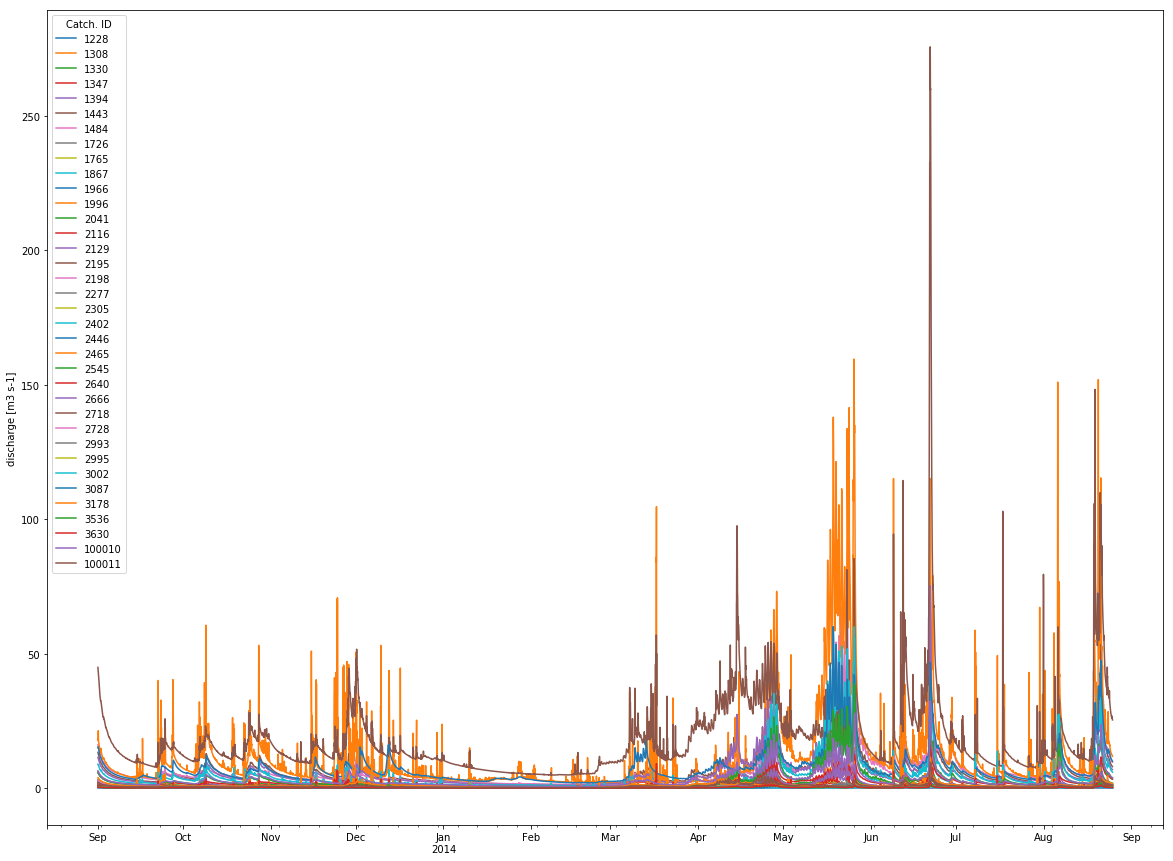

In [16]:
# Here we are going to extact data from the simulation.
# We start by creating a list to hold discharge for each of the subcatchments.
# Then we'll get the data from the region_model object

# mapping of internal catch ID to catchment
catchment_ids = model.catchment_ids

# First get the time-axis which we'll use as the index for the data frame
ta = model.time_axis
# and convert it to datetimes
index = [dt.datetime.utcfromtimestamp(p.start) for p in ta]

# Now we'll add all the discharge series for each catchment 
data = {}
for cid in catchment_ids:
    # get the discharge time series for the subcatchment
    q_ts = model.statistics.discharge([int(cid)])
    data[cid] = q_ts.values.to_numpy()

df = pd.DataFrame(data, index=index)
# we can simply use:
ax = df.plot(figsize=(20,15))
ax.legend(title="Catch. ID")
ax.set_ylabel("discharge [m3 s-1]")